In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os
import configs
from math import ceil, floor

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
from utils_summary_statistics import *
import configs
from Fig3_run_resolution_sweep import param_sweep_search_strengths

# Choose experiment to load

In [2]:
# Specify what you're looking at
exp = 'rec_strength'
model_type = 'default'
exp_df_key = 'rec strength'
exp_label = 'Recurrent Strength'

In [3]:
if os.environ['USER'] == 'chingfang':
    engram_dir = '/Volumes/aronov-locker/Ching/barcodes/' # Local Path
elif 'SLURM_JOBID' in os.environ.keys():
    engram_dir = '/mnt/smb/locker/aronov-locker/Ching/barcodes/' # Axon Path
else:
    engram_dir = '/home/cf2794/engram/Ching/barcodes/' # Cortex Path
exp_dir = os.path.join(engram_dir, 'resolution', exp, model_type)

In [4]:
N_inp = 5000
N_bar = 5000
num_states = 100
inputs = PlaceInputs(N_inp, num_states).get_inputs()

In [5]:
load = True

In [6]:
if load:
    with open(f'resolution_{exp}.p', 'rb') as f:
        summary_stats = pickle.load(f)
else:
    truncate = False
    summary_stats = {}

    for param in os.listdir(exp_dir):
        if param == '.DS_Store': continue
        dirpath = os.path.join(exp_dir, param)
        for site_spacing in os.listdir(dirpath):
            if not site_spacing.startswith('res'): continue    
            dirpath = os.path.join(exp_dir, param, site_spacing)
            for seed in os.listdir(dirpath):
                if not seed.startswith('seed'): continue
                dirpath = os.path.join(exp_dir, param, site_spacing, seed)
                _param = round(float(param), 1)
                _seed = int(seed[4:])
                _site_spacing = int(site_spacing[3:])
                if truncate and (_seed > 5): continue
                cache_states = [0, _site_spacing, 66]

                try:
                    with open(os.path.join(dirpath, 'results.p'), 'rb') as f:
                        _results = pickle.load(f)
                except:
                    continue

                for s in param_sweep_search_strengths:
                    readout = np.linalg.norm(_results[f'{s:.2f}_reconstruct'], axis=1)
                    readout /= readout.max()
                    reconstruct = _results[f'{s:.2f}_reconstruct'].copy()
                    activations = _results[f'{s:.2f}_acts'].copy()
                    _summary_stats = get_resolution_summary_statistics(
                        readout, reconstruct, cache_states, activations,
                        inputs, _site_spacing, search_strength=s)
                    for key, _dict in _summary_stats.items():
                        n_samples = len(_dict[list(_dict.keys())[0]])
                        _dict[exp_df_key] = [_param]*n_samples
                        if key not in summary_stats.keys():
                            summary_stats[key] = _dict
                        else:
                            for nested_key in _dict.keys():
                                summary_stats[key][nested_key].extend(_dict[nested_key])
    with open(f'resolution_{exp}.p', 'wb') as f:
        pickle.dump(summary_stats, f)

# Identifying the Presence of a Cache

### Sensitivity/Specificity at different thresholds

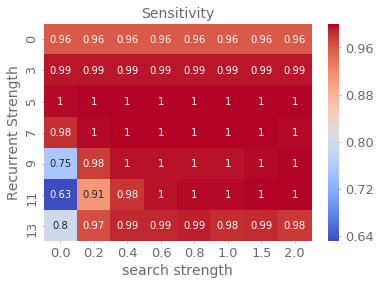

In [7]:
df = pd.DataFrame(summary_stats['identification_1'])
df = df[df[exp_df_key] < 15]
df[exp_df_key] = df[exp_df_key].astype(int)
df = df[df['threshold']==0.5]
df = df.groupby([exp_df_key, 'search strength']).mean().reset_index()
heatmap_data = df.pivot(exp_df_key, 'search strength', 'sensitivity')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Sensitivity')
plt.ylabel(exp_label)
plt.show()

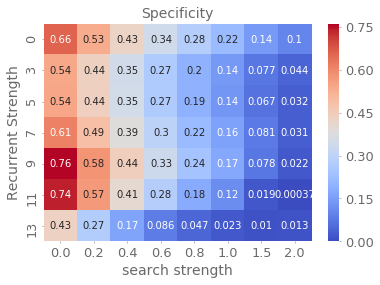

In [8]:
df = pd.DataFrame(summary_stats['identification_1'])
df = df[df[exp_df_key] < 15]
df[exp_df_key] = df[exp_df_key].astype(int)
df = df[df['threshold']==0.5]
df = df.groupby([exp_df_key, 'search strength']).mean().reset_index()
heatmap_data = df.pivot(exp_df_key, 'search strength', 'specificity')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Specificity')
plt.ylabel(exp_label)
plt.show()

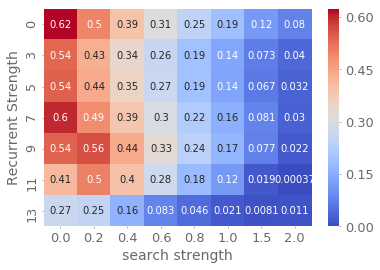

In [9]:
df = pd.DataFrame(summary_stats['identification_1'])
df = df[df[exp_df_key] < 15]
df[exp_df_key] = df[exp_df_key].astype(int)
df['pdt'] = df['specificity'] * df['sensitivity']
df = df[df['threshold']==0.5]
df = df.groupby([exp_df_key, 'search strength']).mean().reset_index()
heatmap_data = df.pivot(exp_df_key, 'search strength', 'pdt')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.ylabel(exp_label)
plt.show()

### How correct are sites between cache 1 and cache 2?

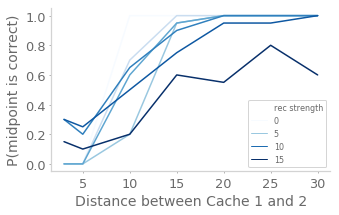

In [10]:
df = pd.DataFrame(summary_stats['identification_2'])
df = df[df[exp_df_key] < 15]
df[exp_df_key] = df[exp_df_key].astype(int)
df = df[df['search strength']==0]
df['binarized'] = df['noncache val'] < 0.5
fig, ax = plt.subplots(figsize=(5,3))
sns.lineplot(
    x='site spacing', y='binarized',
    ci=None, linewidth=1.5, palette='Blues',
    hue=exp_df_key, ax=ax, data=df)
ax.set_ylabel('P(midpoint is correct)')
ax.set_xlabel('Distance between Cache 1 and 2')
plt.show()

### Are you correct at non-caches away from a cache site?

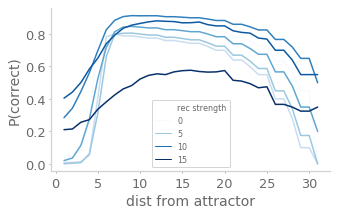

In [11]:
df = pd.DataFrame(summary_stats['identification_3'])
df = df[df[exp_df_key] < 15]
df[exp_df_key] = df[exp_df_key].astype(int)
df = df[df['search strength']==0]
df['binarized'] = df['val'] < 0.5
fig, ax = plt.subplots(figsize=(5,3))
sns.lineplot(
    x='dist from attractor', y='binarized',
    ci=None, linewidth=1.5, palette='Blues',
    hue=exp_df_key, ax=ax, data=df)
plt.ylabel('P(correct)')
plt.show()

# Reconstruction

### Probability of valid attractor given optimal attractor distance

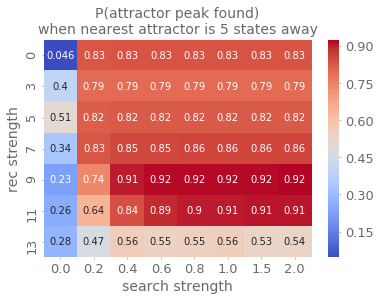

In [23]:
df = pd.DataFrame(summary_stats['reconstruct_1'])
df = df[df[exp_df_key] < 15]
df[exp_df_key] = df[exp_df_key].astype(int)
df = df[df['opt attractor dist']==5]
df = df.groupby([exp_df_key, 'search strength']).mean().reset_index()
heatmap_data = df.pivot(exp_df_key, 'search strength', 'p_valid')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('P(attractor peak found)\nwhen nearest attractor is 5 states away')
plt.show()

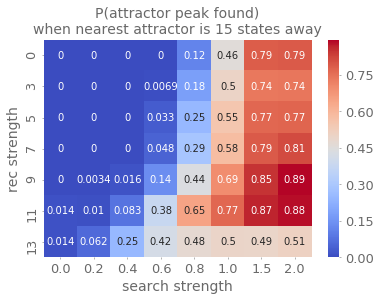

In [24]:
df = pd.DataFrame(summary_stats['reconstruct_1'])
df = df[df[exp_df_key] < 15]
df[exp_df_key] = df[exp_df_key].astype(int)
df = df[df['opt attractor dist']==15]
df = df.groupby([exp_df_key, 'search strength']).mean().reset_index()
heatmap_data = df.pivot(exp_df_key, 'search strength', 'p_valid')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('P(attractor peak found)\nwhen nearest attractor is 15 states away')
plt.show()

### Conditioned on validity, what is the error?

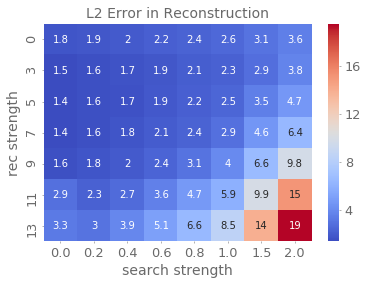

In [30]:
df = pd.DataFrame(summary_stats['reconstruct_2'])
df = df[df[exp_df_key] < 15]
df[exp_df_key] = df[exp_df_key].astype(int)
df = df[df['opt attractor dist']<15]
df = df.groupby([exp_df_key, 'search strength']).mean().reset_index()
heatmap_data = df.pivot(exp_df_key, 'search strength', 'norm error')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('L2 Error in Reconstruction')
plt.show()

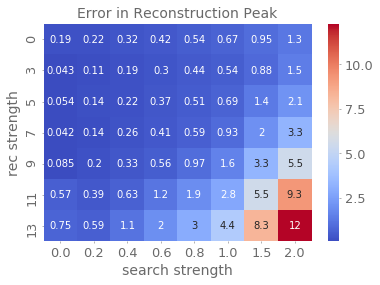

In [31]:
df = pd.DataFrame(summary_stats['reconstruct_2'])
df = df[df[exp_df_key] < 15]
df[exp_df_key] = df[exp_df_key].astype(int)
df = df[df['opt attractor dist']<15]
df = df.groupby([exp_df_key, 'search strength']).mean().reset_index()
heatmap_data = df.pivot(exp_df_key, 'search strength', 'chosen attractor dist')
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title('Error in Reconstruction Peak')
plt.show()

# Activations

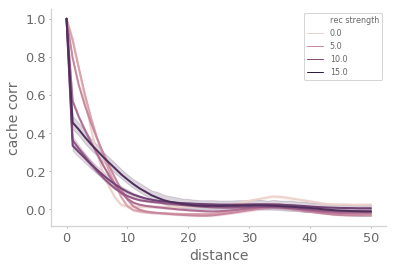

In [17]:
df = pd.DataFrame(summary_stats['activations_1'])
fig, ax = plt.subplots()
sns.lineplot(
    x='distance', y='cache corr', hue=exp_df_key,
    data=df, linewidth=2
    )
plt.show()